In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import Planck13 as cosmo
import fsps
from matplotlib import gridspec
from astropy.io import fits
from astropy import wcs
from astropy.modeling.models import Sersic2D
from astropy.table import Table
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth
from spec_stats import Smooth, Highest_density_region
from spec_id import *
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from sim_engine import forward_model_grism
from astropy.wcs import wcs

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [2]:
if hpath.split('/')[-2][-1] == 'a':
    goodss_rad = Table.read('/Users/vestrada/Downloads/allfields/goodss/goodss_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
    goodsn_rad = Table.read('/Users/vestrada/Downloads/allfields/goodsn/goodsn_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
else:
    goodss_rad = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodss_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
    goodsn_rad = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodsn_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()

In [3]:
morph_db = pd.read_pickle('../dataframes/fitdb/tabfitdb.pkl')
mdb = morph_db.query('zgrism > 0.8 and log_ssfr  > -15')
# mdb = morph_db.query('1.8 < zgrism < 2.2 and log_ssfr  > -15')

inout = []
for i in mdb.index:
    for ii in range(len(mdb.z_50_hci[i])//2):
        if mdb.z_50_hci[i][2*ii] <= mdb.z_50[i] <= mdb.z_50_hci[i][2*ii+1]:
            if (mdb.z_50_hci[i][2*ii+1] - mdb.z_50_hci[i][2*ii]) /2  < 1:
                inout.append('i')
            else:
                inout.append('o')
        
mdb['inout'] = inout
mdb = mdb.query('inout == "i"')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [86]:
mdb.query('id == 21156').zgrism

11    1.25443
Name: zgrism, dtype: float64

In [47]:
GS_seg = fits.open('/Volumes/Vince_CLEAR/gsd_img/goodss_3dhst.v4.0.F160W_seg.fits')[0].data
GN_seg = fits.open('/Volumes/Vince_CLEAR/gnd_img/goodsn_3dhst.v4.0.F160W_seg.fits')[0].data

GS_f160 = fits.open('/Volumes/Vince_CLEAR/gsd_img/goodss_3dhst.v4.0.F160W_orig_sci.fits')[0].data
GN_f160 = fits.open('/Volumes/Vince_CLEAR/gnd_img/goodsn_3dhst.v4.0.F160W_orig_sci.fits')[0].data

GS_cat = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Catalog/goodss_3dhst.v4.4.cat', format = 'ascii').to_pandas()
GN_cat = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Catalog/goodsn_3dhst.v4.4.cat', format = 'ascii').to_pandas()

In [70]:
w = wcs.WCS(fits.open('/Volumes/Vince_CLEAR/gsd_img/goodss_3dhst.v4.0.F160W_seg.fits')[0].header)

In [75]:
p1 = []
p2 = []

for i in range(100):
    x1 = np.random.randint(500)
    y1 = np.random.randint(500)
    
    pos1 = w.wcs_pix2world([[x1,y1], [x1,y1+100]],1)
    x1 = np.random.randint(500)
    y1 = np.random.randint(500)
    pos2 = w.wcs_pix2world([[x1,y1], [x1+100,y1]],1)

    p1.append(np.diff(pos1.T[1])*60*60/100)
    p2.append(-np.diff(pos2.T[0])*60*60/100)

In [77]:
np.percentile(p1,50)

0.059999145807836385

In [87]:
newimg = np.load('../data/imgfiles/GND_21156.npy')

In [5]:
field = 'GND'
galaxy =  21156

if field == 'GND':
    segmap = np.array(GN_seg)
    f125 = np.array(GN_f125)
else:
    segmap = np.array(GS_seg)
    f125 = np.array(GS_f125)

idx = np.argwhere(segmap == galaxy)

ylist = np.arange(min(idx.T[0]), max(idx.T[0]) + 1, 1)
xlist = np.arange(min(idx.T[1]), max(idx.T[1]) + 1, 1)

segimg = segmap[min(idx.T[0]): max(idx.T[0]), min(idx.T[1]): max(idx.T[1])]
f125img = f125[min(idx.T[0]): max(idx.T[0]), min(idx.T[1]): max(idx.T[1])]
f125img[segimg != galaxy] = 0

ycnt = ylist[np.argmax(np.sum(f125img, axis=1))]
xcnt = xlist[np.argmax(np.sum(f125img.T, axis=1))]

f125img = f125[ycnt - 20: ycnt + 20, xcnt - 20: xcnt + 20]
segmask = segimg[ycnt - 20: ycnt + 20, xcnt - 20: xcnt + 20]
f125img[segmask != galaxy] = 0
# nimg, nlow, nhigh = Light_contours(f125img, lim2 = 1)

# for u in range(1,20,1):
#     ring = []
#     for uu in range(len(nimg)):
#         for uuu in range(len(nimg)):
#             if np.round(np.sqrt((uu-20)**2 + (uuu-20)**2),0) == u:
#                 ring.append(nimg[uu][uuu])
#     if np.mean(ring) < nhigh:
#         radius = u
#         break

# newimg = np.zeros_like(nimg)

# for u in range(len(newimg)):
#     for uu in range(len(newimg)):
#         if np.sqrt((u-50)**2 + (uu-50)**2) < radius:
#             newimg[u][uu] = nimg[u][uu]

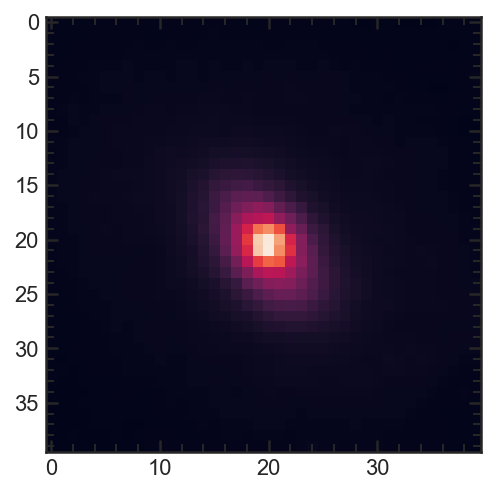

In [6]:
plt.imshow(f125img)
# plt.contour(nimg,np.array([nhigh, nlow]),colors='r',linewidths=2)

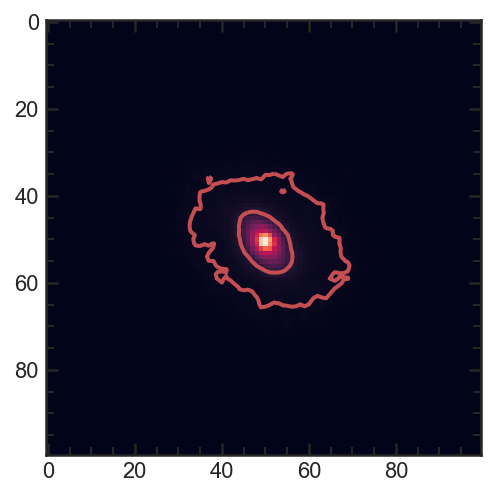

In [87]:
nimg, nlow, nhigh = Light_contours(newimg, lim1=0.5,lim2 = 0.8)
plt.imshow(newimg)
plt.contour(nimg,np.array([nhigh, nlow]),colors='r',linewidths=2)

In [55]:
goodsn_rad.query('NUMBER == 21156')
r = goodsn_rad.re[goodsn_rad.NUMBER == 21156].values * np.sqrt(goodsn_rad.q[goodsn_rad.NUMBER == 21156].values)

In [3]:
goodsn_rad.query('NUMBER == 21156')


,NUMBER,RA,DEC,f,mag,dmag,re,dre,n,dn,q,dq,pa,dpa,sn
21155,21156,189.23941,62.247547,1,20.7688,0.005867,0.455586,0.004106,4.1068,0.065355,0.5461,0.004783,-39.3649,0.54834,594.631


In [7]:
39.36*(np.pi/180)

0.6869615935849681

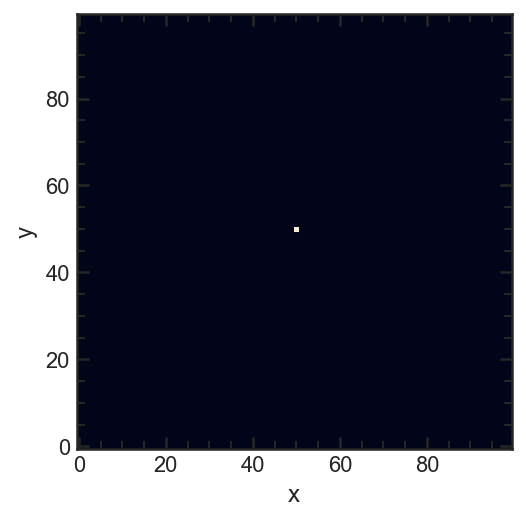

In [85]:
x,y = np.meshgrid(np.arange(100), np.arange(100))

mod = Sersic2D(amplitude = 1, r_eff = 10, n=4.1068, x_0=50, y_0=50,
               ellip=.5461, theta=-39.3649*(np.pi/180))
img = mod(x, y)

plt.figure()
plt.imshow(img, origin='lower')
plt.xlabel('x')
plt.ylabel('y')
# cbar = plt.colorbar()
cbar.set_label('Log Brightness', rotation=270, labelpad=25)
cbar.set_ticks([-1, 0, 1, 2], update_ticks=True)
plt.show()

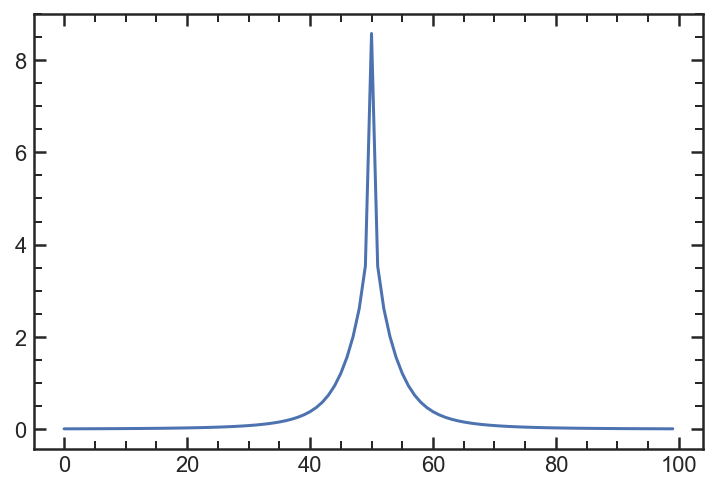

In [84]:
plt.plot(np.arcsinh(img[50]))

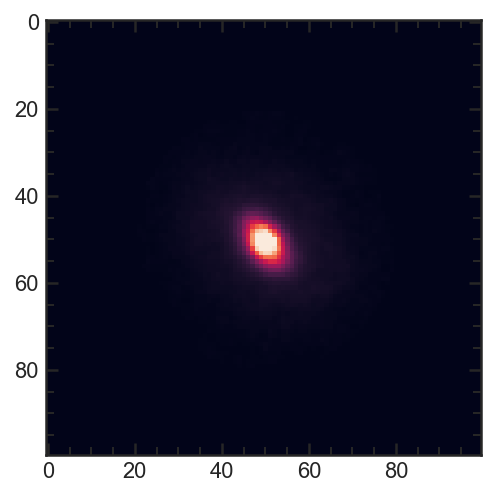

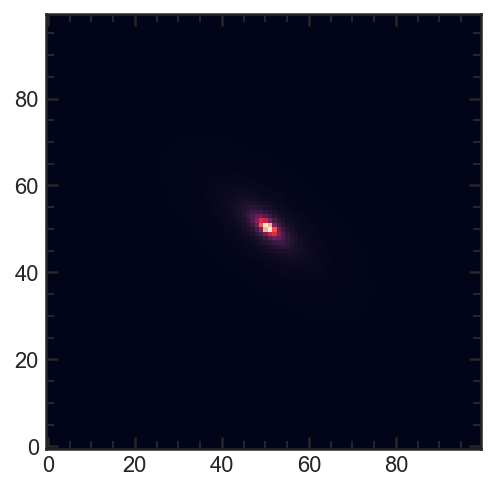

In [67]:
plt.figure()
plt.imshow(np.arcsinh(newimg), vmin = 0, vmax = 0.006)


plt.figure()
plt.imshow(np.arcsinh(img / np.max(img)*np.max(newimg)), vmin = 0, vmax = 0.006,origin='lower')

In [87]:
r/0.064,r/0.13,

(array([5.26049345]), array([2.58978139]))

In [ ]:
plt.imshow(newimg)


In [37]:
from mpl_toolkits.mplot3d import Axes3D

In [42]:
X,Y = np.meshgrid(np.arange(100),np.arange(100))

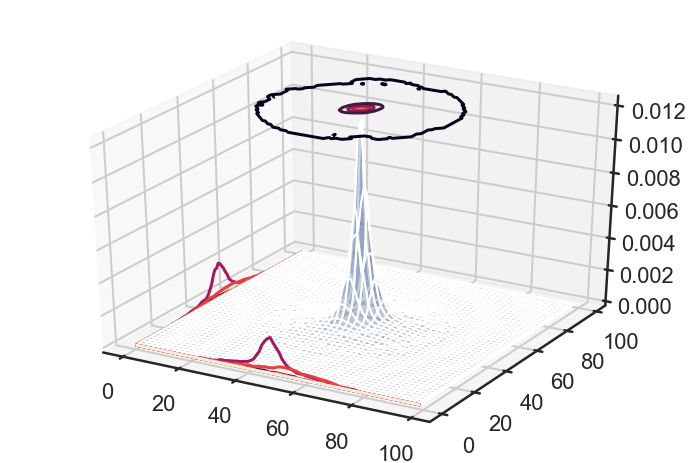

In [130]:
X=X
Y=Y
Z = newimg

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, Z, alpha=0.3)
cset = ax.contour(X, Y, Z, zdir='z', offset=0.013, )
cset = ax.contour(X, Y, Z, zdir='x', offset=0)
cset = ax.contour(X, Y, Z, zdir='y', offset=0)

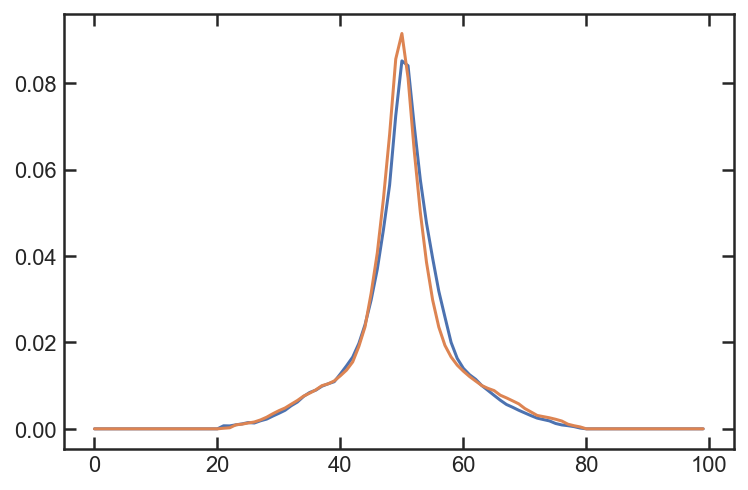

In [139]:
# s1=np.sum(newimg, axis=1) / np.trapz(np.sum(newimg, axis=1))
# s2=np.sum(newimg, axis=0) / np.trapz(np.sum(newimg, axis=0))

plt.plot(s1)
plt.plot(s2)

In [140]:
Highest_density_region(s1,np.arange(100),region=0.50),Highest_density_region(s2,np.arange(100),region=0.50)

((50, [47, 54]), (50, [46, 53]))

In [66]:
def rescale_img(img,zspec):
    yarc = 100*0.06; xarc = 100*0.068

    ykpc = yarc/cosmo.arcsec_per_kpc_proper(zspec).value
    xkpc = xarc/cosmo.arcsec_per_kpc_proper(zspec).value
    xnew = np.linspace(xkpc/2 - 20, xkpc/2 + 20,40)
    ynew = np.linspace(ykpc/2 - 20, ykpc/2 + 20,40)

    inimg = interp2d(np.arange(1,101,1)*xkpc/100,np.arange(1,101,1)*ykpc/100, newimg)

    return inimg(xnew,ynew)

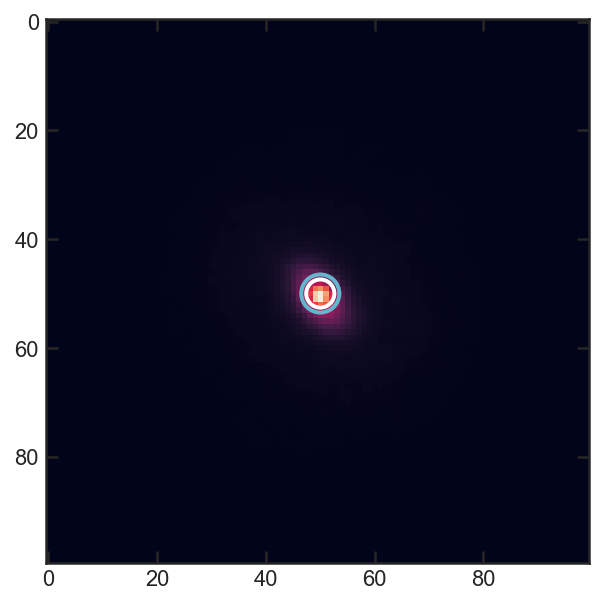

In [136]:
plt.figure(figsize=[5,5])
ax = plt.subplot()
# plt.imshow(newimg[30:70,30:70])
plt.imshow(newimg)

circle1=plt.Circle((50,50),radius=2.59,ec='w',fc='none', linewidth=2)
circle2=plt.Circle((50,50),radius=3.5,ec='c',fc='none', linewidth=2)
ax.add_artist(circle1)
ax.add_artist(circle2)



In [111]:
cimgs = np.zeros([100,100])
eimgs = np.zeros([100,100])
pixels = np.arange(0, cimgs.shape[0] ,1)

for i in mdb.index:
    newimg = np.load('../data/imgfiles/{0}_{1}.npy'.format(mdb.field[i], mdb.id[i]))
    
#     nimg, nlow, nhigh = Light_contours(rescale_img(newimg, mdb.zgrism[i]), lim2 = .95)
    if mdb.compact[i] == 'c':
        cimgs += rescale_img(newimg, mdb.zgrism[i])
    if mdb.compact[i] == 'e':
        eimgs += rescale_img(newimg, mdb.zgrism[i])

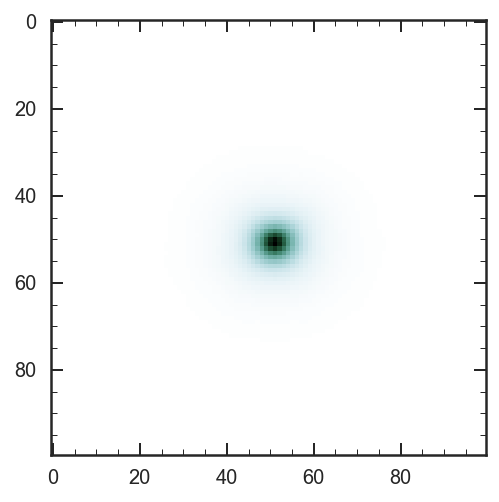

In [112]:
plt.imshow(cimgs, cmap=cmap)

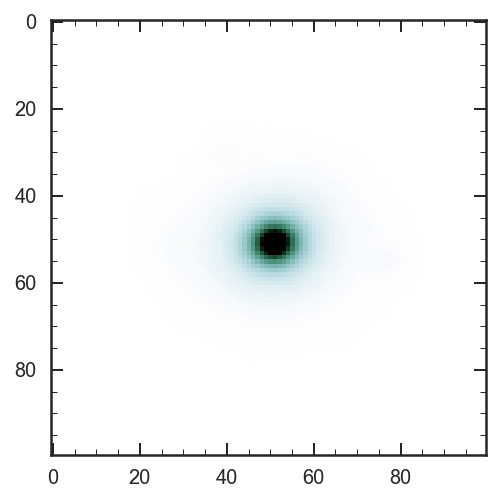

In [114]:
plt.imshow(eimgs, cmap=cmap, vmin = 0, vmax = .5)

In [11]:
for i in mdb.index:
    if mdb.field[i] == 'GND':
        segmap = np.array(GN_seg)
        f125 = np.array(GN_f125)
    else:
        segmap = np.array(GS_seg)
        f125 = np.array(GS_f125)

    idx = np.argwhere(segmap == mdb.id[i])

    ylist = np.arange(min(idx.T[0]), max(idx.T[0]) + 1, 1)
    xlist = np.arange(min(idx.T[1]), max(idx.T[1]) + 1, 1)

    segimg = segmap[min(idx.T[0]): max(idx.T[0]), min(idx.T[1]): max(idx.T[1])]
    f125img = f125[min(idx.T[0]): max(idx.T[0]), min(idx.T[1]): max(idx.T[1])]
    f125img[segimg != mdb.id[i]] = 0

    ycnt = ylist[np.argmax(np.sum(f125img, axis=1))]
    xcnt = xlist[np.argmax(np.sum(f125img.T, axis=1))]

    f125img = f125[ycnt - 50: ycnt + 50, xcnt - 50: xcnt +50]
    segmask = segimg[ycnt - 50: ycnt + 50, xcnt - 50: xcnt +50]
    f125img[segmask != mdb.id[i]] = 0
    nimg, nlow, nhigh = Light_contours(f125img, lim2 = .95)

    for u in range(1,50,1):
        ring = []
        for uu in range(len(nimg)):
            for uuu in range(len(nimg)):
                if np.round(np.sqrt((uu-50)**2 + (uuu-50)**2),0) == u:
                    ring.append(nimg[uu][uuu])
        if np.mean(ring) < nhigh:
            radius = u
            break

    newimg = np.zeros_like(nimg)

    for u in range(len(newimg)):
        for uu in range(len(newimg)):
            if np.sqrt((u-50)**2 + (uu-50)**2) < radius:
                newimg[u][uu] = nimg[u][uu]
                
    np.save('../data/imgfiles/{0}_{1}'.format(mdb.field[i],mdb.id[i]),newimg)

In [119]:
np.save('../data/compact_img', cimgs)
np.save('../data/extend_img', eimgs)

In [30]:
def Light_contours(img, lim1 = 0.2, lim2 = 0.8):
    pixel_num = img.shape[0]
    pixels = np.arange(0, pixel_num ,1)
    ####### normalize img #########
    nimg = img / np.trapz(np.trapz(img, pixels, axis=1), pixels)
    ####### Create array from highest value of P2 to 0
    pbin = np.linspace(0, np.max(nimg), 1000)
    pbin = pbin[::-1]

    ####### 2d integrate to find the 1 and 2 sigma values
    prob_int = np.zeros(len(pbin))

    for i in range(len(pbin)):
        p = np.array(nimg)
        p[p <= pbin[i]] = 0
        prob_int[i] = np.trapz(np.trapz(p, pixels, axis=1), pixels)

    ######## Identify 0.5 and 95 percentiles
    onesig = np.abs(np.array(prob_int) - lim1)
    twosig = np.abs(np.array(prob_int) - lim2)

    return nimg, pbin[np.argmin(onesig)], pbin[np.argmin(twosig)]

In [115]:
ncimg, clow, chigh = Light_contours(cimgs)
neimg, elow, ehigh = Light_contours(eimgs)

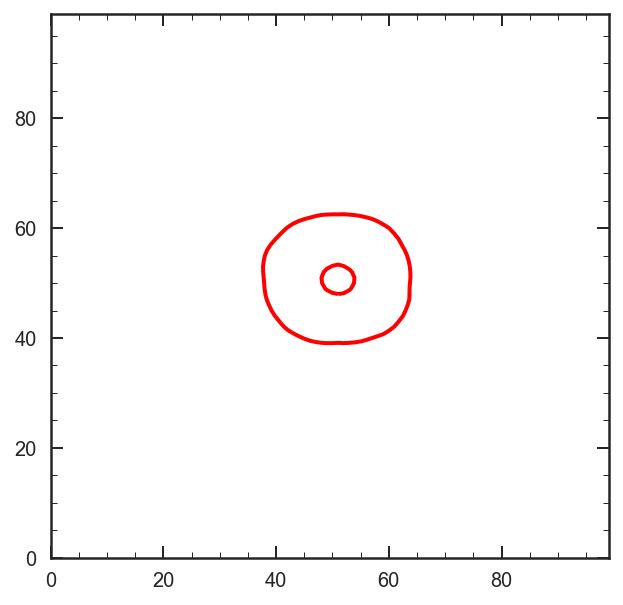

In [116]:
plt.figure(figsize=[5,5])

plt.contour(ncimg,np.array([chigh, clow]),colors='r',linewidths=2)
# plt.contourf(ncimg,40,cmap=cmap)

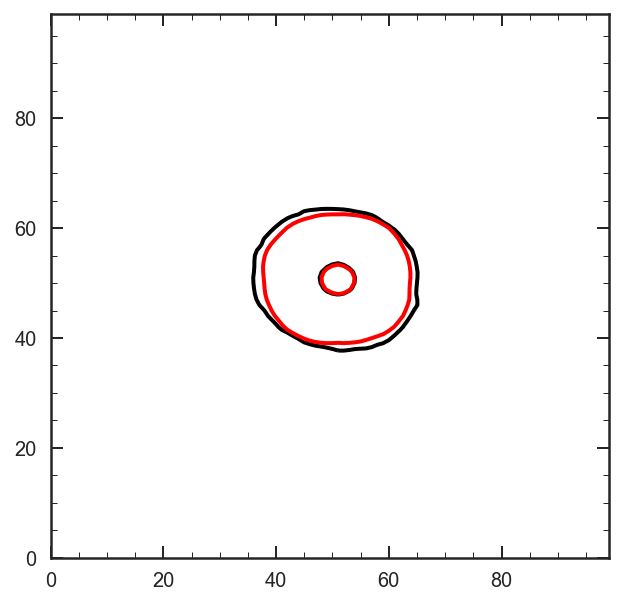

In [117]:
plt.figure(figsize=[5,5])
plt.contour(neimg,np.array([ehigh, elow]),colors='k',linewidths=2)
plt.contour(ncimg,np.array([chigh, clow]),colors='r',linewidths=2)


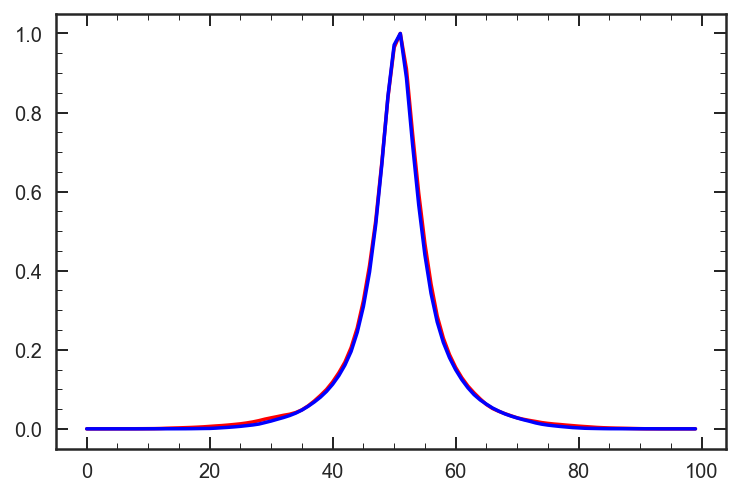

In [118]:
plt.plot(np.sum(eimgs, axis=1)/ max(np.sum(eimgs, axis=1)), 'r')
plt.plot(np.sum(cimgs, axis=1)/ max(np.sum(cimgs, axis=1)),'b')

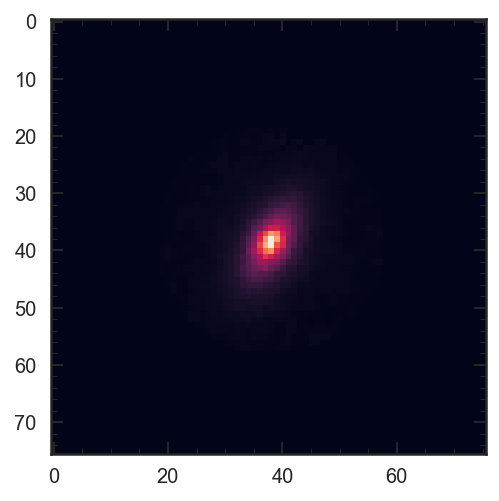

In [288]:
segmap = np.array(GN_seg)
f125 = np.array(GN_f125)

idx = np.argwhere(segmap == 36348)

ylist = np.arange(min(idx.T[0]), max(idx.T[0]) + 1, 1)
xlist = np.arange(min(idx.T[1]), max(idx.T[1]) + 1, 1)

segimg = segmap[min(idx.T[0]): max(idx.T[0]), min(idx.T[1]): max(idx.T[1])]
f125img = f125[min(idx.T[0]): max(idx.T[0]), min(idx.T[1]): max(idx.T[1])]
f125img[segimg != 36348] = 0
maxloc = np.argwhere(f125img == np.max(f125img))[0]

ycnt = ylist[np.argmax(np.sum(f125img, axis=1))]
xcnt = xlist[np.argmax(np.sum(f125img.T, axis=1))]

f125img = f125[ycnt - 38: ycnt + 38, xcnt - 38: xcnt +38]
segmask = segmap[ycnt - 38: ycnt + 38, xcnt - 38: xcnt +38]
f125img[segmask != 36348] = 0

nimg, nlow, nhigh = Light_contours(f125img, lim2 = .95)

for u in range(1,38,1):
    ring = []
    for i in range(len(nimg)):
        for ii in range(len(nimg)):
            if np.round(np.sqrt((i-38)**2 + (ii-38)**2),0) == u:
                ring.append(nimg[i][ii])
    if np.mean(ring) < nhigh:
        radius = u
        break

newimg = np.zeros_like(nimg)

for i in range(len(newimg)):
    for ii in range(len(newimg)):
        if np.sqrt((i-38)**2 + (ii-38)**2) < radius:
            newimg[i][ii] = nimg[i][ii]

nimg, nlow, nhigh = Light_contours(newimg, lim2 = .95)

plt.figure()
plt.imshow(nimg)


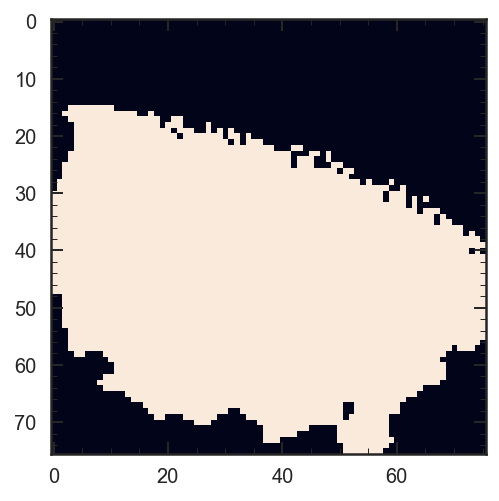

In [132]:
segmask[segmask != 27714] = 0
plt.imshow(segmask)

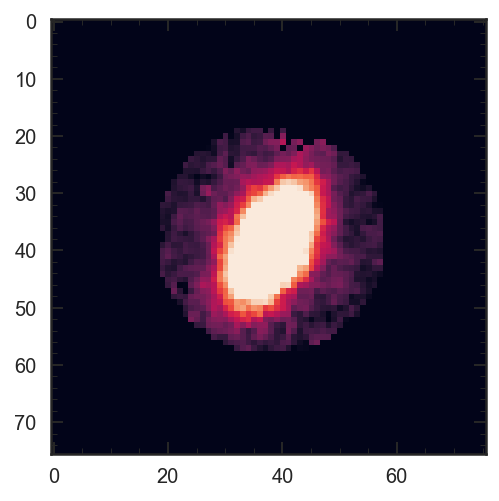

In [289]:
plt.imshow(nimg, vmin = 0, vmax=0.001)


In [262]:
ntimg, tlow, thigh = Light_contours(nimg, lim2 = .95)


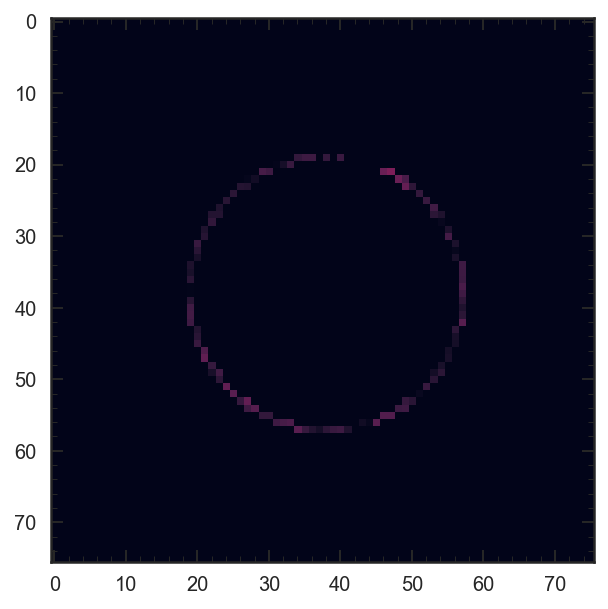

In [280]:
plt.figure(figsize=[5,5])
# plt.contour(ntimg,np.array([thigh, tlow]),colors='r',linewidths=2)
# plt.imshow(nimg, vmin = 0, vmax=0.001)
plt.imshow(newimg, vmin = 0, vmax=0.001)


## stack

In [123]:
flxgrid = []
errgrid = []
swave = np.arange(3000,8000,10)

for i in mdb.index:
    if mdb.compact[i] == 'e':
        field = mdb.field[i]
        galaxy = mdb.id[i]

        m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, lm, z, d, \
        bp1, rp1, ba, bb, bl, ra, rb, rl, lwa, logl = np.load(
            '../data/bestfits/{0}_{1}_tabfit_bfit.npy'.format(field, galaxy))

        Gs = Gen_spec(field, galaxy, z, phot_errterm = 0.04, irac_err = 0.08) 

        wvs, flxs, errs, beams, trans = Gather_grism_data(Gs)

        sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)
        sp.params['dust2'] = d
        sp.params['dust1'] = d
        sp.params['logzsol'] = np.log10(m)

        time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

        sp.set_tabular_sfh(time,sfr)    

        wave, flux = sp.get_spectrum(tage = a, peraa = True)    

        Gmfl, Pmfl = Full_forward_model(Gs, wave, F_lam_per_M(flux,wave*(1+z),z,0,sp.stellar_mass)*10**lm, z, 
                                        wvs, flxs, errs, beams, trans)
        
        MFLX = F_lam_per_M(flux,wave*(1+z),z,0,sp.stellar_mass)*10**lm

        IDX = [U for U in range(len(wave)) if 3000 < wave[U] < 6000]

        Nfact = np.trapz(MFLX[IDX],wave[IDX])
        
        sidx = 0
        sflux = np.zeros(len(swave))
        serror = np.zeros(len(swave))
        
        
        if Gs.g102:
            bcal = Calibrate_grism([wvs[sidx], flxs[sidx], errs[sidx]], Gmfl[sidx], bp1)[0]
            bscale = Scale_model( flxs[sidx] / bcal,errs[sidx]/ bcal,Gmfl[sidx])
            iBflx =interp1d(Gs.Bwv_rf,flxs[sidx] / bcal/ bscale / Nfact, fill_value=0, bounds_error=False)(swave)
            iBerr =interp1d(Gs.Bwv_rf,errs[sidx] / bcal/ bscale / Nfact, fill_value=0, bounds_error=False)(swave)
            sflux += iBflx
            serror += iBerr
            
            sidx += 1
            
        if Gs.g141:
            rcal = Calibrate_grism([wvs[sidx], flxs[sidx], errs[sidx]], Gmfl[sidx], rp1)[0]
            rscale =Scale_model( flxs[sidx] / rcal,errs[sidx]/ rcal,Gmfl[sidx])
            iRflx =interp1d(Gs.Rwv_rf,flxs[sidx] / rcal/ rscale / Nfact, fill_value=0, bounds_error=False)(swave)
            iRerr =interp1d(Gs.Rwv_rf,errs[sidx] / rcal/ rscale / Nfact, fill_value=0, bounds_error=False)(swave)
            sflux += iRflx
            serror += iRerr

        serror[serror == 0] = 1E5
        
        flxgrid.append(sflux)
        errgrid.append(serror)        

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/minico

missing g102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/minico

missing g102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g141


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/minico

missing g141


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda

missing g102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/minico

missing g102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/e

missing g102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/e

missing g102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


In [121]:
def Stack(wv, flxgrid , errgrid):
    flgrid = np.transpose(flxgrid)
    errgrid = np.transpose(errgrid)
    weigrid = errgrid ** (-2)
    infmask = np.isinf(weigrid)
    weigrid[infmask] = 0
    ################

    stack, err = np.zeros([2, len(wv)])
    for i in range(len(wv)):
        stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))        
        err[i] = 1 / np.sqrt(np.sum(weigrid[i]))
    ################
    
    return stack, err

In [124]:
seflux, seerror = Stack(swave, flxgrid, errgrid)

<ErrorbarContainer object of 3 artists>

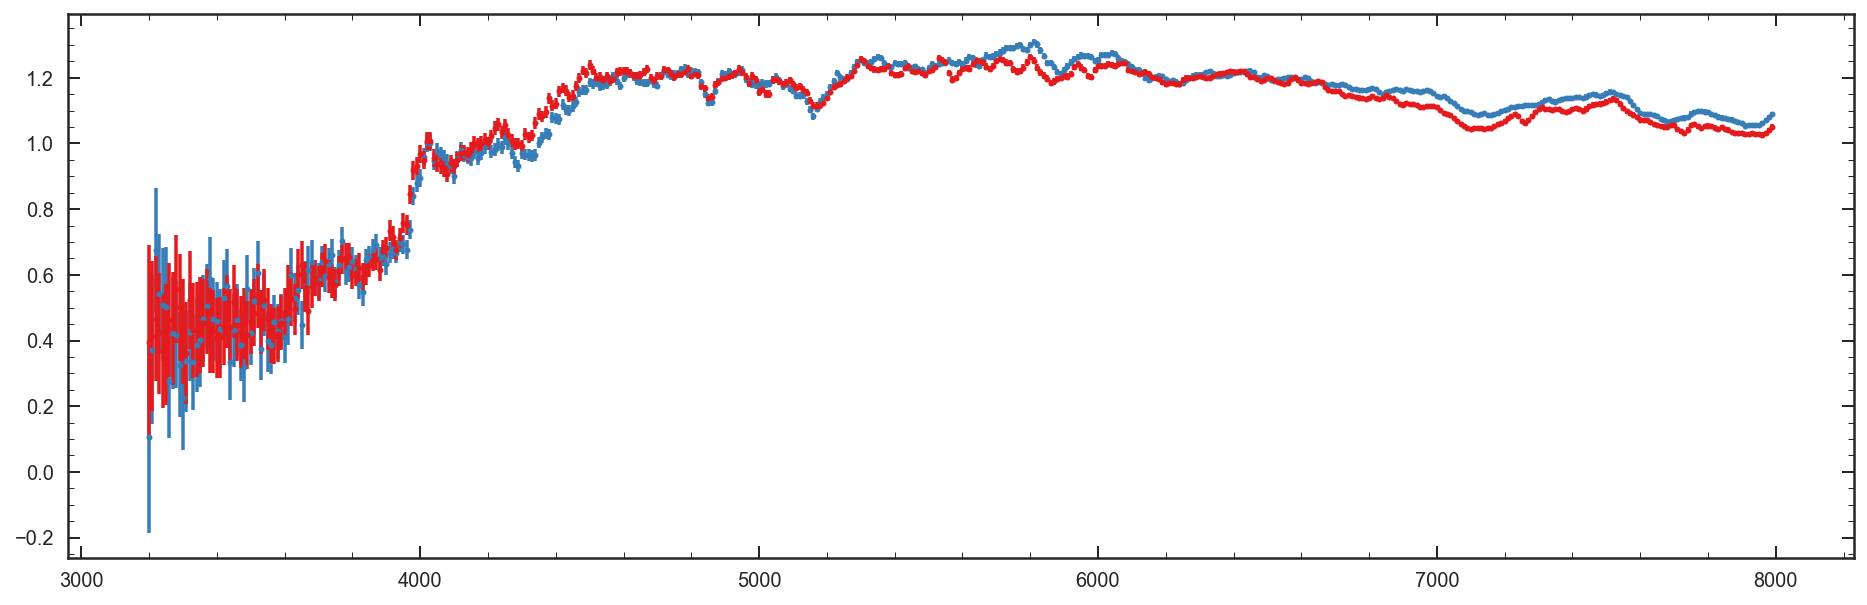

In [128]:
plt.figure(figsize=[16,5])

plt.errorbar(swave[20:], scflux[20:] / scflux[120], scerror[20:]/ scflux[120],
            linestyle='None', marker='o', markersize=3, color='#377eb8', zorder = 2)
plt.errorbar(swave[20:], seflux[20:] / seflux[120], scerror[20:] / seflux[120],
            linestyle='None', marker='o', markersize=3, color='#e41a1c', zorder = 2)


In [129]:
np.save('../data/compact_spec', [swave[20:], scflux[20:] / scflux[120], scerror[20:] / scflux[120]])
np.save('../data/extended_spec', [swave[20:], seflux[20:] / seflux[120], scerror[20:] / seflux[120]])

In [5]:
plt.figure(figsize=[16,5])
###############plot tab##################

if Gs.g102:
    plt.errorbar(Gs.Bwv_rf,flxs[0]/ bcal/bscale / Nfact,errs[0] / bcal/bscale / Nfact,
            linestyle='None', marker='o', markersize=3, color='#377eb8', zorder = 2)

if Gs.g141:
    plt.errorbar(Gs.Rwv_rf,flxs[1]/  rcal /rscale / Nfact,errs[1] / rcal/rscale / Nfact,
            linestyle='None', marker='o', markersize=3, color='#e41a1c', zorder = 2)


plt.title(galaxy, fontsize=25)
plt.xlabel('Wavelength ($\AA$)', fontsize=20)
plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)



IndexError: index 1 is out of bounds for axis 0 with size 1

<Figure size 1152x360 with 0 Axes>

<ErrorbarContainer object of 3 artists>

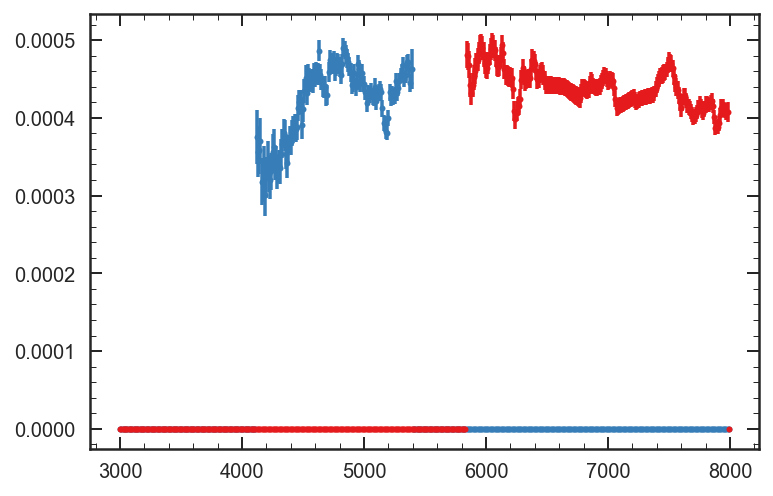

In [36]:
plt.errorbar(swave, iBflx, iBerr,
        linestyle='None', marker='o', markersize=3, color='#377eb8', zorder = 2)

plt.errorbar(swave, iRflx, iRerr,
        linestyle='None', marker='o', markersize=3, color='#e41a1c', zorder = 2)

(0, 0.0006)

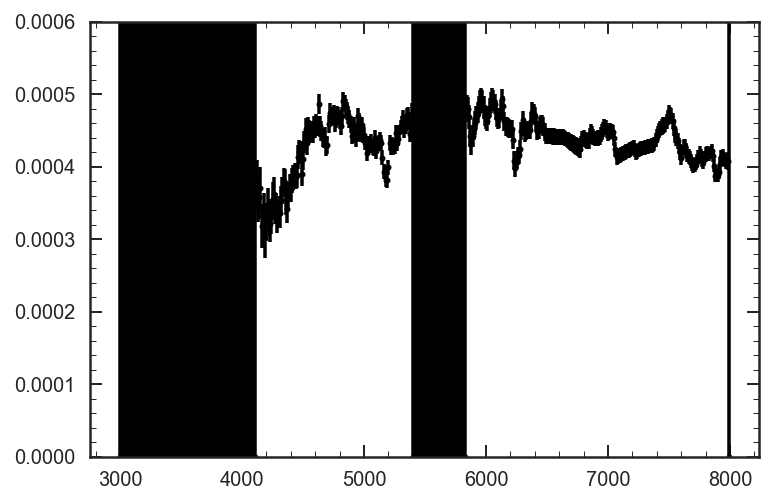

In [38]:
plt.errorbar(swave, sflux, serror,
        linestyle='None', marker='o', markersize=3, color='k', zorder = 2)
plt.ylim(0,0.0006)

# plot spec

In [2]:
cimg = np.load('../data/compact_img.npy')
eimg = np.load('../data/extend_img.npy')

cwave, cflux, cerror = np.load('../data/compact_spec.npy')
ewave, eflux, eerror = np.load('../data/extended_spec.npy')

In [5]:
ncimg, clow, chigh = Light_contours(cimg)
neimg, elow, ehigh = Light_contours(eimg)

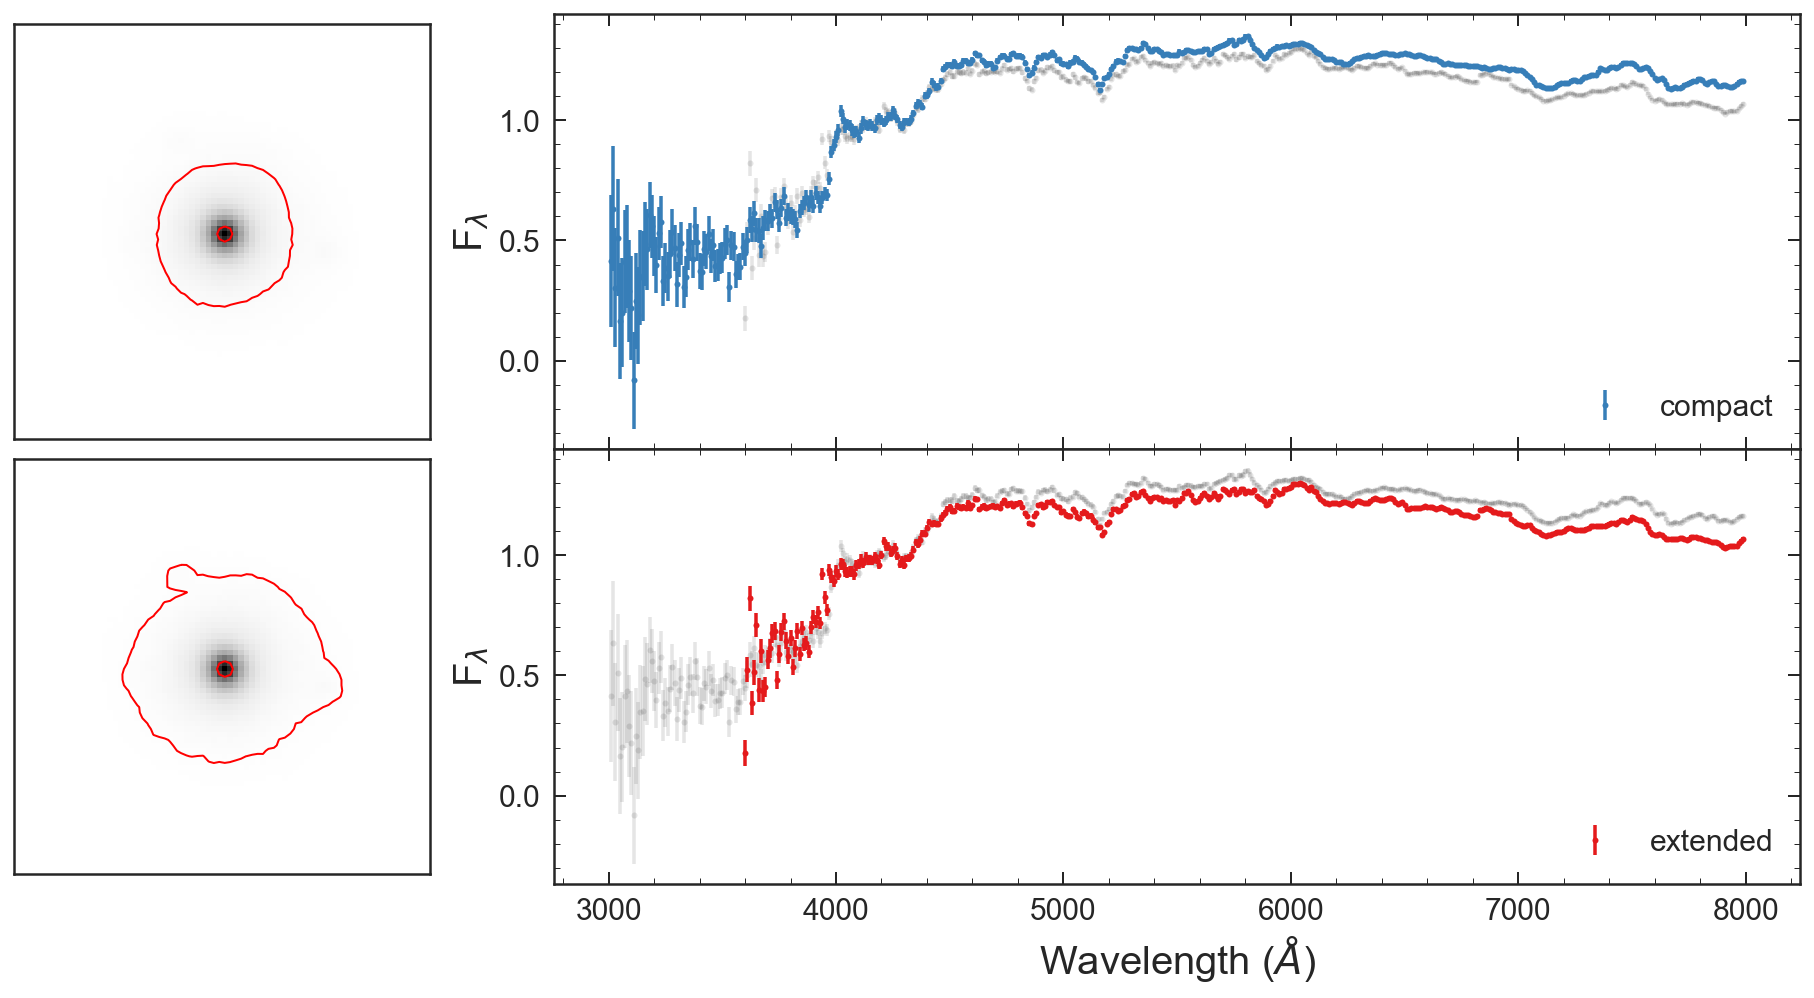

In [7]:
gs = gridspec.GridSpec(2,2, width_ratios=[1,3], hspace=0, wspace = 0.15)

plt.figure(figsize=[16,8])

plt.subplot(gs[0,0])
plt.imshow(np.arcsinh(eimg), cmap= 'binary')
plt.contour(ncimg,np.array([chigh, clow]),colors='r',linewidths=1)
plt.xticks([])
plt.yticks([])

plt.subplot(gs[0,1])
plt.errorbar(cwave, cflux, cerror,
            linestyle='None', marker='o', markersize=3, color='#377eb8', zorder = 2, label = 'compact')
plt.errorbar(ewave, eflux, eerror,
            linestyle='None', marker='o', markersize=3, color='k', alpha = 0.1, zorder = 1)

plt.legend(fontsize = 15, loc = 4)
plt.ylabel('F$_\lambda$', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=15)
plt.subplot(gs[1,0])
plt.imshow(eimg, cmap= 'binary')
plt.contour(neimg,np.array([ehigh, elow]),colors='r',linewidths=1)
plt.xticks([])
plt.yticks([])

plt.subplot(gs[1,1])
plt.errorbar(cwave, cflux, cerror,
            linestyle='None', marker='o', markersize=3, color='k', alpha = 0.1, zorder = 1)
plt.errorbar(ewave, eflux, eerror,
            linestyle='None', marker='o', markersize=3, color='#e41a1c', zorder = 2, label = 'extended')
plt.legend(fontsize = 15, loc = 4)
plt.xlabel('Wavelength ($\AA$)', fontsize=20)
plt.ylabel('F$_\lambda$', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=15)

plt.savefig('../plots/morph/com_ext_spec.png', bbox_inches = 'tight')

In [3]:
if hpath.split('/')[-2][-1] == 'a':
    goodss_f125 = Table.read('/Users/vestrada/Downloads/allfields/goodss/goodss_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
    goodsn_f125 = Table.read('/Users/vestrada/Downloads/allfields/goodsn/goodsn_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
    goodss_f160 = Table.read('/Users/vestrada/Downloads/allfields/goodss/goodss_3dhst.v4.1_f160w.galfit',format='ascii').to_pandas()
    goodsn_f160 = Table.read('/Users/vestrada/Downloads/allfields/goodsn/goodsn_3dhst.v4.1_f160w.galfit',format='ascii').to_pandas()
    
else:
    goodss_f125 = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodss_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
    goodsn_f125 = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodsn_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
    goodss_f160 = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodss_3dhst.v4.1_f125w.60lfit',format='ascii').to_pandas()
    goodsn_f160 = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodsn_3dhst.v4.1_f125w.60lfit',format='ascii').to_pandas()

In [65]:
mdb = pd.read_pickle('../dataframes/fitdb/tabfitdb.pkl')

In [66]:
mdb

,Av,Av_hci,Z,Z_hci,lmass,lmass_hci,lwa,lwa_hci,m1,m10,...,compact_B_f125,B_f125,compact_A_f160,A_f160,compact_B_f160,B_f160,Sigma1_f125,Sigma1_f160,compact_Sigma1_f125,compact_Sigma1_f160
0,0.27072,"[0.16922023342214415, 0.3580560675700637]",0.75357,"[0.6427262520689969, 0.8671865202330316]",10.79707,"[10.770714354486511, 10.821257505720784]",1.41730,"[1.2408923459070103, 1.6393306216773929]",0.00000,0.14365,...,c,10.348744,e,2.853887,c,10.342211,2.487509e+09,2.320700e+09,e,e
1,0.13549,"[0.03333105658762661, 0.049222412652579, 0.077...",1.41771,"[0.6338131478058413, 0.7200674611962807, 1.194...",10.86442,"[10.837165363620215, 10.88423375909862]",2.71107,"[2.454791254460413, 2.939315102405706]",0.00011,0.16494,...,e,10.251129,e,3.215215,e,10.256133,2.596482e+09,2.585028e+09,e,e
2,0.17152,"[0.11569269961542136, 0.2413008041752247]",0.89462,"[0.6516357102494938, 0.9647152625060016]",10.46598,"[10.44008321536899, 10.50482517507497]",2.71486,"[2.4381404669329747, 3.2406272775366247]",0.00000,0.78901,...,e,9.811059,e,6.562665,e,9.841132,1.276912e+09,1.263945e+09,e,e
3,0.00507,"[0.0011661896663650536, 0.009293930123635582]",0.99176,"[0.9122671008283152, 1.097094323705967]",11.01559,"[10.988143970307299, 11.037892807435993]",3.63991,"[3.33549039614645, 3.893600805267345]",0.00000,0.94542,...,c,10.641342,c,1.579953,c,10.700085,4.369184e+09,4.306795e+09,c,c
4,0.00147,"[0.0014707817236648646, 0.01739946409891359]",0.82400,"[0.7544230763540225, 1.042650243255692]",10.57585,"[10.503025809075433, 10.539929091953166, 10.55...",1.99219,"[1.5676583165841524, 1.7211028480583856, 1.823...",0.00012,0.29781,...,e,9.880236,e,5.388381,e,9.955831,1.648986e+09,1.643248e+09,e,e
5,0.00225,"[0.00225108705715933, 0.019414927062710877]",1.30184,"[1.2292647132981889, 1.442159500213116]",10.78714,"[10.773405537133566, 10.799543179003244]",2.76391,"[2.6888050549689497, 2.8437071577951682]",0.00013,0.95037,...,c,10.516912,c,2.163307,c,10.523930,2.722928e+09,2.654915e+09,e,e
6,0.00201,"[0.0020145302202840693, 0.052519956693499695]",1.16452,"[0.4568167665178864, 0.6829296770275027, 1.049...",10.25492,"[10.206523417059142, 10.278379447279498, 10.28...",2.22912,"[1.918809986709987, 2.57469077185118, 3.378673...",0.00013,0.24848,...,e,9.774896,e,5.351245,e,10.000453,9.198435e+08,9.498710e+08,e,e
7,0.56370,"[0.512329566425902, 0.6222407649997757]",0.64298,"[0.5184121410611915, 0.7980493166267904]",10.97864,"[10.934452175895153, 11.012366242734007]",2.44959,"[1.7935869121104167, 1.8411237242643808, 2.050...",0.00007,0.40573,...,c,10.734564,c,1.446952,c,10.761989,3.717800e+09,3.727104e+09,c,c
8,0.00155,"[0.0015527535596045338, 0.020233460014779187, ...",0.99734,"[0.6887251014973826, 0.834104166234187, 0.8417...",11.15457,"[11.124766866079527, 11.179050965228331]",2.95779,"[2.4348050681914764, 3.0898529253676963]",0.00003,0.35155,...,c,11.277919,c,0.362396,c,11.641904,7.294480e+09,7.769812e+09,c,c
9,0.00146,"[0.0014613948810399337, 0.05211225821095711]",0.77024,"[0.6613905628015446, 0.9829769697468576, 1.052...",10.33242,"[10.298292104932647, 10.356505913551764]",2.23322,"[2.030126556956171, 2.5734147704881147]",0.00004,0.27579,...,e,10.274689,e,3.014587,c,10.364606,1.201895e+09,1.263879e+09,e,e


In [37]:
def Fphot(field, galaxy_id, phot):
    if phot.lower() == 'f125':
        bfilters = 203
    if phot.lower() == 'f160':
        bfilters = 205

    W, F, E, FLT = np.load(phot_path + '{0}_{1}_phot.npy'.format(field, galaxy_id))

    return (F[FLT == bfilters] * W[FLT == bfilters]**2 / 3E18)[0]

## $\Sigma_1 = M_*(<1$ kpc)/$ \pi (1$ kpc)$^2$

$M_∗(< 1kpc) =\frac{\int ^{1kpc} _0I(r)2πrdr}{\int ^\inf _0 I(r)2πrdr} \frac {L_{galfit}}{L_{phot}}M_{phot}$

$I(R)=I_{e}exp\left\{-b_{n}\left[\left({\frac {R}{R_{e}}}\right)^{1/n}-1\right]\right\}$

$L_{galfit}$ - total integrated luminosity from sersic profile

$L_{phot}$ - total luminosity using certain photometry measurment

$M_{phot}$ - Mass measurment

$b_n = 2n - 1/3$

update: $I_{e} 2\pi e^{b_{n}}\int ^{1kpc} _0 R e^\left[-b_{n}\left({\frac {R}{R_{e}}}\right)^{1/n}\right]dR$

$M_∗(< 1kpc) =\frac{\int^{1kpc}_0 I'_{R} dR}
{\int^\inf_0 I'_{R} dR} \frac {L_{galfit}}{L_{phot}}M_{phot}$

$I'_{R} = R e^\left[-b_{n}\left({\frac {R}{R_{e}}}\right)^{1/n}\right]$

In [21]:
catalog = Table.read('/Users/vestrada/Desktop/catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/Catalog/goodsn_3dhst.v4.1.cat', format='ascii').to_pandas()

galfit = Table.read('/Users/vestrada/Downloads/allfields/goodsn/goodsn_3dhst.v4.1_f125w.galfit', format='ascii').to_pandas()

In [22]:
fphot = catalog.query('id == 21156').f_F125W.values[0]
n = galfit.query('NUMBER == 21156').n.values[0]
Reff = 2.88442
mgal = galfit.query('NUMBER == 21156').mag.values[0]

In [68]:
galfit.query('NUMBER == 21156')

,NUMBER,RA,DEC,f,mag,dmag,re,dre,n,dn,q,dq,pa,dpa,sn
21155,21156,189.23941,62.247547,1,20.7688,0.005867,0.455586,0.004106,4.1068,0.065355,0.5461,0.004783,-39.3649,0.54834,594.631


In [74]:
mdb.query('id == 21156')

,Av,Av_hci,Z,Z_hci,lmass,lmass_hci,lwa,lwa_hci,m1,m10,...,t_q,t_q_hci,log_ssfr,log_ssfr_hci,Reff,A,compact_A,compact_B,B,inout
11,0.32545,"[0.2773279343203142, 0.38138107469637544, 0.41...",1.15683,"[0.9922519200446216, 1.2875876213051942]",11.30338,"[11.291310967803888, 11.3281639944103]",2.05076,"[1.6920806185595616, 1.7697044311502144, 1.943...",0.00018,0.12023,...,1.103397,"[0.6867775676743669, 0.7799687363803023, 0.867...",-11.231397,"[-11.39041319291464, -10.958798914704548]",2.88442,1.70814,c,c,10.613292,i


In [58]:
def IR_prime(n, Reff, R):
    b = 2*n - (1/3)  
    return R * np.exp(-b * (R / Reff)**(1/n))

def Sigma_1(field, galaxy, filt, gfit_cat):
    grow = mdb.query('id == {0}'.format(galaxy))
    Reff = grow['Re_{0}'.format(filt)].values[0]
    n = grow['n_{0}'.format(filt)].values[0]
    mass = 10**grow['lmass'].values[0]
    
    mgal = gfit_cat.query('NUMBER == {0}'.format(galaxy)).mag.values[0]    
    
    r_range = np.linspace(0,1,1000)
    top = np.trapz(IR_prime(n, Reff, r_range), r_range)
    
    r_range = np.linspace(0,100,100000)
    bottom = np.trapz(IR_prime(n, Reff, r_range), r_range)   
    
    Lgal = 10**((mgal + 48.6) / -2.5)   
    return (top / bottom)*(Lgal / Fphot(field, galaxy, phot))*mass / np.pi**2

In [76]:
np.log10(Sigma_1(n, Reff, mgal, fphot, 10**11.3))

9.731937827917491

In [38]:
np.log10(Sigma_1(n, Reff, mgal, 10**11.3, 'GND', 21156, 'f125'))

9.741570628534433

In [59]:
np.log10(Sigma_1('GND', 21156, 'f125', galfit))

9.744950577917672

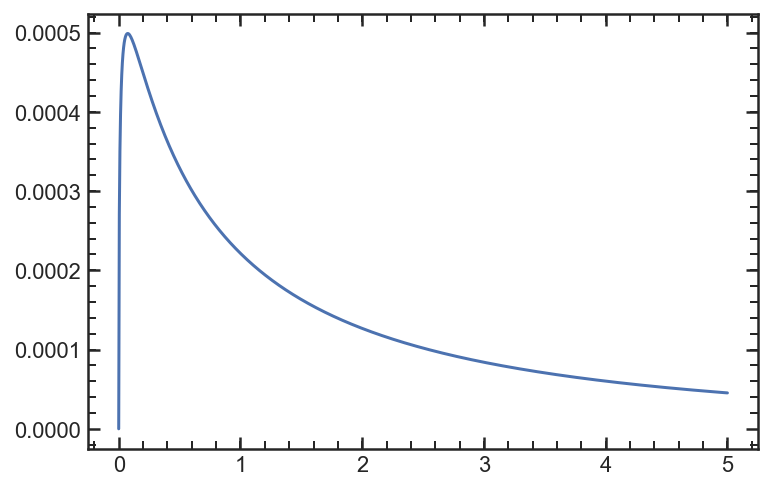

In [36]:
r_range = np.linspace(0,5,1000)

plt.plot(r_range, integral_R(5,2,r_range))

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


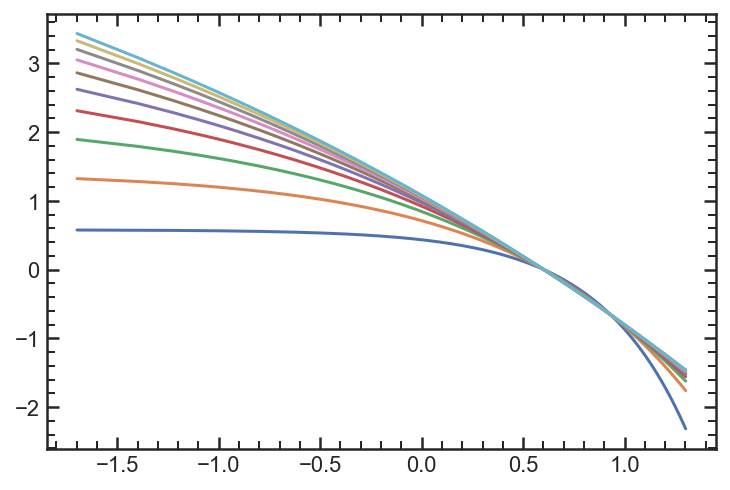

In [60]:
r_range = np.linspace(0,20,1000)


for i in range(10):
    plt.plot(np.log10(r_range), np.log10(IR_prime(i+1,5,r_range) / IR_prime(i+1,5,r_range)[200]))


# Attempt to fit 

make sure to make newimg above

In [7]:
X, Y = np.meshgrid(np.arange(40), np.arange(40))

mod = Sersic2D(amplitude = 1, r_eff = 10, n=4.1068, x_0=20, y_0=20,
               ellip=.5461, theta=-39.3649*(np.pi/180))
img = mod(X, Y)

In [8]:
def Scale_model(D, sig, M):
    return np.sum(((D * M) / sig ** 2)) / np.sum((M ** 2 / sig ** 2))

In [10]:
newimg = f125img

In [11]:
SC = Scale_model(newimg, 0.1 * np.max(newimg), img)

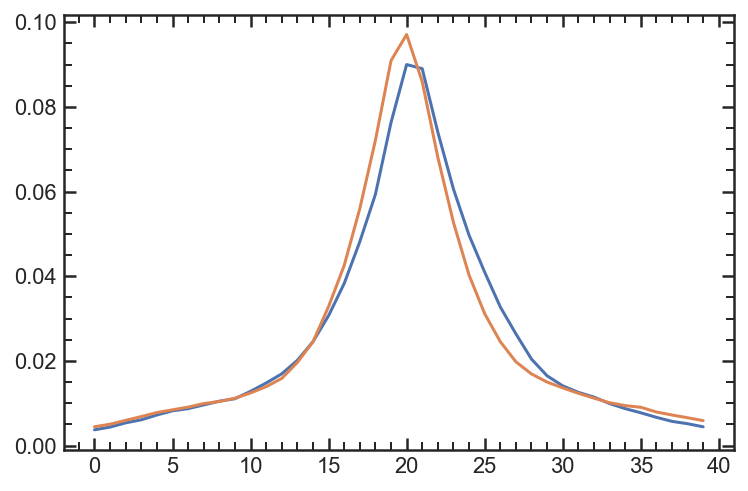

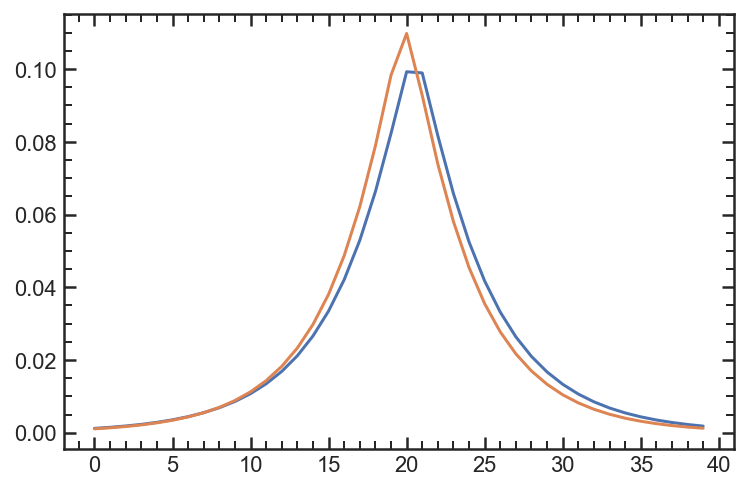

In [27]:
s1=np.sum(newimg, axis=1) / np.trapz(np.sum(newimg, axis=1))
s2=np.sum(newimg, axis=0) / np.trapz(np.sum(newimg, axis=0))

plt.figure()
plt.plot(s1)
plt.plot(s2)

s1=np.sum(img, axis=1) / np.trapz(np.sum(img, axis=1))
s2=np.sum(img, axis=0) / np.trapz(np.sum(img, axis=0))

plt.figure()
plt.plot(s1)
plt.plot(s2)

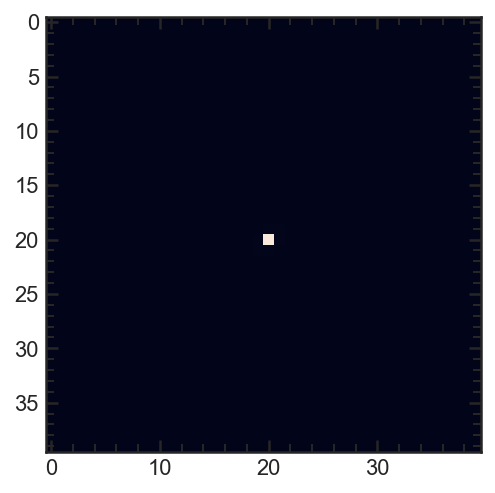

In [17]:
plt.imshow(img)

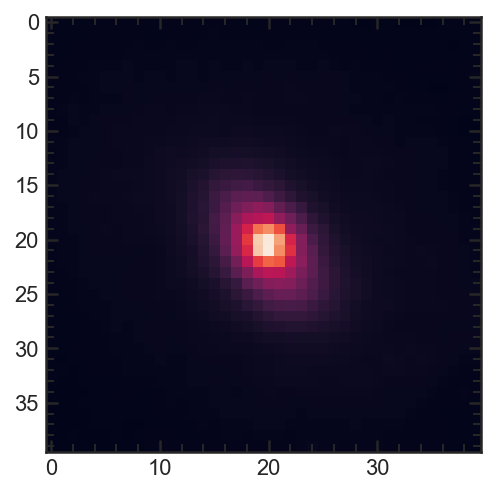

In [131]:
plt.imshow(newimg[30:70,30:70])

In [18]:
import dynesty
from spec_id import log_10_prior, Gaussian_prior
from multiprocessing import Pool
    
verbose=False
poolsize = 8

Xgrid, Ygrid = np.meshgrid(np.arange(40), np.arange(40))

img_err = 0.1 * np.max(newimg)

def morph_prior(u):
#     a = 
    r = (10)* u[0] + 0.1 
    n = (10)* u[1] + 0.1
    x0 = Gaussian_prior(u[2], [0, 100], 20, 3)
    y0 = Gaussian_prior(u[3], [0, 100], 20, 3)
    e = u[4]
    t = 360 * u[5]
        
    return [r, n, x0, y0, e, t]

def morph_L(X):
    r, n, x0, y0, e, t = X
    
    mod = Sersic2D(amplitude = 1, r_eff = r, n = n, x_0 = x0, y_0 = y0,
                   ellip= e, theta= t * (np.pi/180))
    img = mod(Xgrid, Ygrid)
   
    SC = Scale_model(newimg, img_err, img)

    return  - np.sum( ((newimg - SC * img) / (img_err))**2 ) /2

In [19]:
#######set up dynesty########
sampler = dynesty.DynamicNestedSampler(morph_L, morph_prior, ndim = 6,
                                         pool=Pool(processes=8), queue_size=8)


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/Vince.ec/miniconda3/envs/astroconda/lib

In [20]:

sampler.run_nested(wt_kwargs={'pfrac': 1.0}, dlogz_init=0.01, print_progress=True)

dres = sampler.results

iter: 26196 | batch: 8 | bound: 426 | nc: 4 | ncall: 221069 | eff(%): 11.850 | loglstar: -19.808 < -12.232 < -13.179 | logz: -30.260 +/-  0.166 | stop:  0.935            


In [22]:
dres.samples[-1]

array([  6.27914908,   1.28893318,  19.86047091,  20.48097255,
         0.27288922, 231.34823891])

In [23]:
mod = Sersic2D(amplitude = 1, r_eff = 6.27914908, n = 1.28893318, x_0 = 19.86047091, y_0 = 20.48097255,
                   ellip= 0.27288922, theta= 231.34823891 * (np.pi/180))
img = mod(Xgrid, Ygrid)

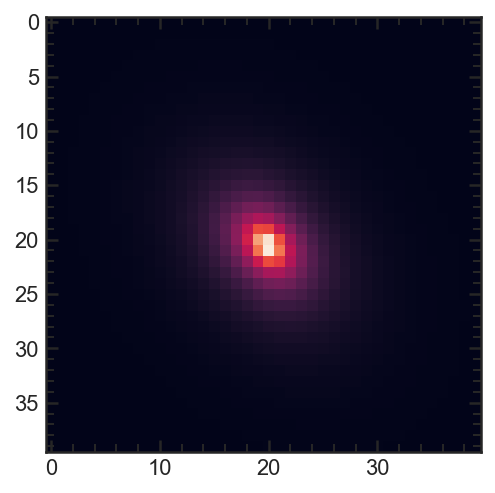

In [24]:
plt.imshow(img)

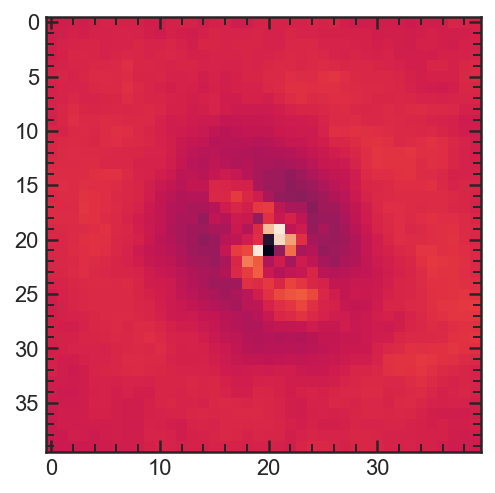

In [26]:
SC = Scale_model(newimg, img_err, img)
plt.imshow(f125img - SC * img)

# compare van der wel

In [2]:
if hpath.split('/')[-2][-1] == 'a':
    goodss_rad = Table.read('/Users/vestrada/Downloads/allfields/goodss/goodss_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
    goodsn_rad = Table.read('/Users/vestrada/Downloads/allfields/goodsn/goodsn_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
else:
    goodss_rad = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodss_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
    goodsn_rad = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodsn_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()

In [3]:
f125_cand =  Table.read('../data/morph_cat/GS_f125w.cat',format='ascii').to_pandas()

In [5]:
f=open('../data/table2.dat', "rt")

fl = f.readlines()

'Fld |F| ID| RAdeg DEdeg |Q| mag| e_mag| r| e_r| n| e_n| q| e_q| PA| e_PA| S/N'

i = 0
idx = 0

ID = []
ra =[]
dec =[]
r = []
q = []
Q = []
for row in fl:
    if row.split('|')[0] == 'GOODSS' and row.split('|')[1] == 'J':
        ID.append(float(row.split('|')[2]))
        ra.append(float(row.split('|')[3].split(' ')[1]))
        dec.append(float(row.split('|')[3].split(' ')[2]))
        r.append(float(row.split('|')[7]))
        q.append(float(row.split('|')[11]))
        Q.append(int(row.split('|')[4]))
f125_t2 = pd.DataFrame({'ra' : ra, 'dec' : dec, 'r': r, 'q' : q, 'id' : ID, 'Q':Q})

In [77]:
def find_cand_id(gal_ra, gal_dec, gal_ids, cat_ra, cat_dec):
    r = (1. / 60 / 60) * 0.5
    galid = []
    for i in range(len(gal_ra)):
        cosr = np.sin(np.radians(gal_dec[i])) * np.sin(np.radians(cat_dec)) + np.cos(np.radians(gal_dec[i]))\
                * np.cos(np.radians(cat_dec)) * np.cos(np.radians(gal_ra[i]) - np.radians(cat_ra))
        rad = np.arccos(cosr)
        rad = np.degrees(rad)
        for ii in range(len(rad)):
            if rad[ii] < r:
                galid.append(gal_ids[i])
    return galid

In [10]:
f125_cand[['NUMBER','RA','DEC', 're', 'q', 'f']][0:10]

,NUMBER,RA,DEC,re,q,f
0,1,53.092995,-27.954536,1.804670,0.3145,2
1,2,53.102886,-27.959661,0.341922,0.3368,0
2,3,53.101685,-27.958477,0.472536,0.2657,0
3,4,53.102272,-27.958649,0.077748,0.4838,0
4,5,53.090557,-27.958498,0.252120,0.6848,2
5,6,53.099937,-27.958279,0.293010,0.4478,1
6,7,53.096146,-27.957590,1.165270,0.1680,0
7,8,53.091537,-27.958361,0.094680,0.3946,0
8,9,53.089596,-27.958027,0.097890,0.3811,1
9,10,53.090965,-27.957832,0.856236,0.6707,0


In [11]:
f125_t2[['id','ra','dec', 'r', 'q', 'Q']][0:10]

,id,ra,dec,r,q,Q
0,1.0,53.092995,-27.954536,1.8047,0.3145,2
1,2.0,53.102886,-27.959661,0.3419,0.3368,0
2,3.0,53.101685,-27.958477,0.4725,0.2657,0
3,4.0,53.102272,-27.958649,0.0777,0.4838,0
4,5.0,53.090557,-27.958498,0.2521,0.6848,2
5,6.0,53.099937,-27.958279,0.2930,0.4478,1
6,7.0,53.096146,-27.957590,1.1653,0.1680,0
7,8.0,53.091537,-27.958361,0.0947,0.3946,0
8,9.0,53.089596,-27.958027,0.0979,0.3811,1
9,10.0,53.090965,-27.957832,0.8562,0.6707,0


In [47]:
morph_db = pd.read_pickle('../dataframes/fitdb/fullfitdb.pkl')

inout = []
for i in morph_db.index:
    for ii in range(len(morph_db.zgrism_hci[i])//2):
        if morph_db.zgrism_hci[i][2*ii] <= morph_db.zgrism[i] <= morph_db.zgrism_hci[i][2*ii+1]:
            if(morph_db.zgrism_hci[i][2*ii+1] - morph_db.zgrism_hci[i][2*ii]) /( 2 * (1 + morph_db.zgrism[i])) < 0.01:
                inout.append('i')
            else:
                inout.append('o')
        
morph_db['inout'] = inout
morph_db = morph_db.query('inout == "i" and n_f < 3 and Re < 20 and AGN == "-"')

mdb = morph_db.query('n_f < 3 and lmass >= 10.5')


In [84]:
goodss_rad.query('NUMBER == 48464')[['NUMBER','RA','DEC', 're', 'dre', 'q', 'f']]

,NUMBER,RA,DEC,re,dre,q,f
48463,48464,53.144817,-27.68247,0.428028,0.02244,0.552,1


In [85]:
f125_cand.query('NUMBER == 24740')[['NUMBER','RA','DEC', 're', 'dre', 'q', 'f']]

,NUMBER,RA,DEC,re,dre,q,f
24739,24740,53.144825,-27.682474,0.597954,0.029537,0.5525,1


In [82]:
f125_t2.query('id == 24740')[['id','ra','dec', 'r', 'q', 'Q']]

,id,ra,dec,r,q,Q
24739,24740.0,53.144825,-27.682474,0.598,0.5525,1


In [80]:
find_cand_id(f125_cand.RA.values, f125_cand.DEC.values, f125_cand.NUMBER.values, [53.144817],[-27.68247])

[24740]

0
1
0
1
1
0
0
0
1
39012
1
1
48464


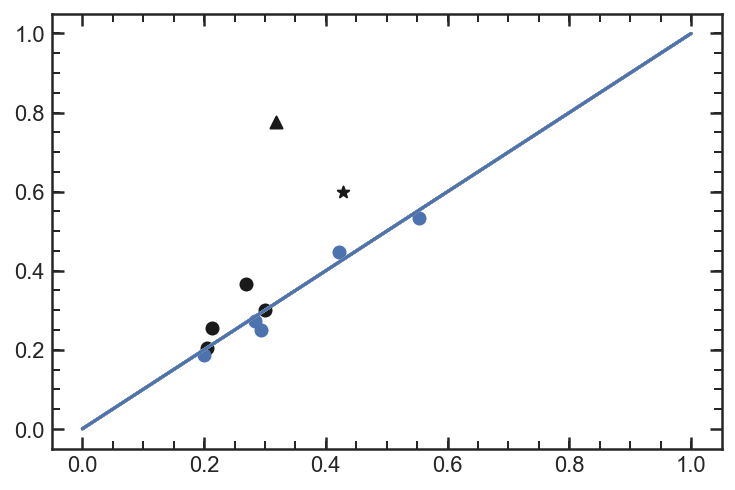

In [71]:
for i in mdb.query('field == "GSD" and Sigma1 > 10**10.2').index:
    ra = goodss_rad.query('NUMBER == {}'.format(mdb.id[i])).RA.values[0]
    dec = goodss_rad.query('NUMBER == {}'.format(mdb.id[i])).DEC.values[0]
    re =  goodss_rad.query('NUMBER == {}'.format(mdb.id[i])).re.values[0]
    q = goodss_rad.query('NUMBER == {}'.format(mdb.id[i])).f.values[0]
    
    idcand = find_cand_id(f125_cand.RA.values, f125_cand.DEC.values, f125_cand.NUMBER.values, [ra],[dec])[0]
    re_t2 = f125_t2.query('id == {}'.format(idcand)).r.values[0]
    re_cd = f125_cand.query('NUMBER == {}'.format(idcand)).re.values[0]
    f = f125_cand.query('NUMBER == {}'.format(idcand)).f.values[0]
    markers = ['o','*','^']
    colors = ['b','k','r'] 
    print(q)
    if f > 0 :
        print(mdb.id[i])
    plt.scatter(re,re_cd,color=colors[int(q)],marker=markers[f])
    plt.plot([0,1],[0,1])

# RS img test

In [42]:
from spec_tools import Posterior_spec

GS_seg = fits.open('/Volumes/Vince_CLEAR/gsd_img/goodss_3dhst.v4.0.F160W_seg.fits')[0].data
GS_f125 = fits.open('/Volumes/Vince_CLEAR/gsd_img/goodss_3dhst.v4.0.F125W_orig_sci.fits')[0].data
GS_f160 = fits.open('/Volumes/Vince_CLEAR/gsd_img/goodss_3dhst.v4.0.F160W_orig_sci.fits')[0].data


def IMG_pull(field, galaxy, zspec):    
    if field == 'GND':
        segmap = np.array(GN_seg)
        if zspec <= 1.5:
            filt = np.array(GN_f125)
            w = wcs.WCS(fits.open('/Volumes/Vince_CLEAR/gnd_img/goodsn_3dhst.v4.0.F125W_orig_sci.fits')[0].header)
            
        else:
            filt = np.array(GN_f160)
            w = wcs.WCS(fits.open('/Volumes/Vince_CLEAR/gnd_img/goodsn_3dhst.v4.0.F160W_orig_sci.fits')[0].header)
        
    else:
        segmap = np.array(GS_seg)
        if zspec <= 1.5:
            filt = np.array(GS_f125)
            w = wcs.WCS(fits.open('/Volumes/Vince_CLEAR/gsd_img/goodss_3dhst.v4.0.F125W_orig_sci.fits')[0].header)
            
        else:
            filt = np.array(GS_f160)
            w = wcs.WCS(fits.open('/Volumes/Vince_CLEAR/gsd_img/goodss_3dhst.v4.0.F160W_orig_sci.fits')[0].header)
               
    idx = np.argwhere(segmap == galaxy)

    yrange = np.arange(min(idx.T[0]), max(idx.T[0]) + 1,1)
    xrange = np.arange(min(idx.T[1]), max(idx.T[1]) + 1,1)  

    segimg = segmap[min(idx.T[0])-20: max(idx.T[0])+21, min(idx.T[1])-20: max(idx.T[1])+21]
    filtimg = np.array(filt[min(idx.T[0])-20: max(idx.T[0])+21, min(idx.T[1])-20: max(idx.T[1])+21])   
    return filtimg

def rescale_img(img):   
    xmax,ymax = np.argwhere(img == np.max(img))[0][::-1]
    yrange = np.arange(img.shape[0])
    xrange = np.arange(img.shape[1])    


    new_x = np.linspace(xmax - int(4/0.06)/2, xmax + int(4/0.06)/2,  int(4/0.06) )
    new_y = np.linspace(ymax - int(4/0.06)/2, ymax + int(4/0.06)/2,  int(4 /0.06))

    inimg = interp2d(xrange, yrange, img, bounds_error=False, fill_value=0)
    return inimg(new_x,new_y)

In [43]:
galaxies = [40597, 40476, 39850]
zspec = [1.218653, 1.212179, 0.979554]
for i in range(len(galaxies)):
    img = IMG_pull('GSD', galaxies[i], zspec[i])
    np.save('../data/imgfiles/GSD_{0}_img'.format(galaxies[i]),img)
    
    
    img = np.load('../data/imgfiles/GSD_{0}_img.npy'.format(galaxies[i]))
    rsimg = rescale_img(img)

    np.save('../data/imgfiles/GSD_{0}_rsimg'.format(galaxies[i]),rsimg)    

In [35]:
img = np.load('../data/imgfiles/GSD_40862_img.npy')

In [36]:
rsimg = rescale_img(img)

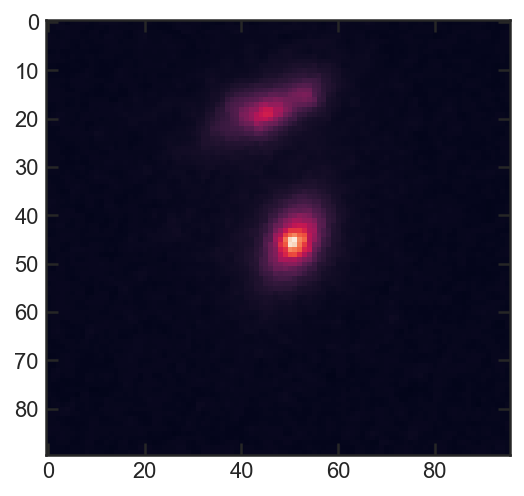

In [37]:
plt.imshow(img)

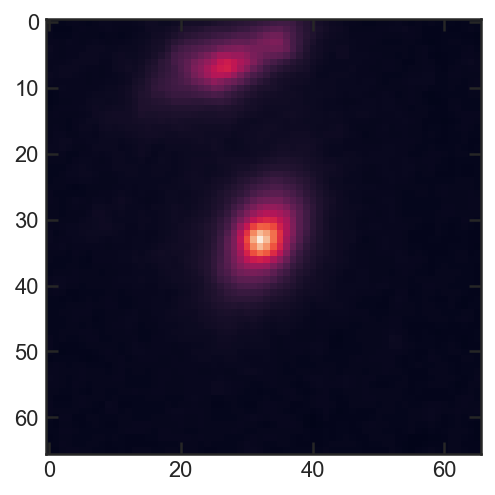

In [38]:
plt.imshow(rsimg)

In [7]:
alldb = pd.read_pickle('../dataframes/fitdb/all_1d_fits.pkl')
# morph_db = pd.read_pickle('../dataframes/fitdb/fullfitdb.pkl')
# morph_db = alldb.query('UVJ == "Q" and AGN != "AGN" and lmass >= 10.5 and n_f < 3 and Re < 20 and Sigma1 > 10**9.7')
morph_db = alldb.query('UVJ == "Q" and AGN != "AGN" and lmass >= 10.5 and n_f < 3 and Re < 20 ')

bspec = [27458,294464,36348,48631,19290,32566,32691,33093,26272,35640,45333]
nog141 = [27915,37955,17746,17735]
nog102 = [27714,37189,26139,32799,47223,22774,28890,23073,31452,24033]

inout = []
for i in morph_db.index:
#     if(morph_db.zgrism_hci[i][1] - morph_db.zgrism_hci[i][0]) /( 2 * (1 + morph_db.zgrism[i])) < 0.01 and \
#     morph_db.id[i] not in bspec and morph_db.id[i] not in nog102:
        
    if morph_db.id[i] not in bspec and morph_db.id[i] not in nog102: 
        inout.append('i')
    else:
        inout.append('o')
        
morph_db['inout'] = inout
mdb = morph_db.query('inout == "i" and 0.7 < zgrism < 2.5 and Sigma1 > 10**9.6')


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
mdb = mdb.query('z_50 > 3.4')

In [10]:
hsdb = mdb.query('Sigma1 > 10**10.2')
lsdb = mdb.query('Sigma1 < 10**10.0')

In [91]:
def IMG_pull(field, galaxy, zspec):    
    if field == 'GND':
        segmap = np.array(GN_seg)
        filt = np.array(GN_f160)
        w = wcs.WCS(fits.open('/Volumes/Vince_CLEAR/gnd_img/goodsn_3dhst.v4.0.F160W_orig_sci.fits')[0].header)
        
    else:
        segmap = np.array(GS_seg)
        filt = np.array(GS_f160)
        w = wcs.WCS(fits.open('/Volumes/Vince_CLEAR/gsd_img/goodss_3dhst.v4.0.F160W_orig_sci.fits')[0].header)
               
    idx = np.argwhere(segmap == galaxy)

    yrange = np.arange(min(idx.T[0]), max(idx.T[0]) + 1,1)
    xrange = np.arange(min(idx.T[1]), max(idx.T[1]) + 1,1)  

    segimg = segmap[min(idx.T[0])-30: max(idx.T[0])+31, min(idx.T[1])-30: max(idx.T[1])+31]
    filtimg = np.array(filt[min(idx.T[0])-30: max(idx.T[0])+31, min(idx.T[1])-30: max(idx.T[1])+31])   
    return filtimg

In [100]:
for i in hsdb.index:
    if mdb.field[i] == 'GND':
        segmap = np.array(GN_seg)
        f160 = np.array(GN_f160)
        cat = GN_cat
    else:
        segmap = np.array(GS_seg)
        f160 = np.array(GS_f160)
        cat = GS_cat

#     idx = np.argwhere(segmap == mdb.id[i])

#     ylist = np.arange(min(idx.T[0]), max(idx.T[0]) + 1, 1)
#     xlist = np.arange(min(idx.T[1]), max(idx.T[1]) + 1, 1)

#     ycnt = ylist[np.argmax(np.sum(f160img, axis=1))]
#     xcnt = xlist[np.argmax(np.sum(f160img.T, axis=1))]

    xcnt, ycnt = np.array([cat.query('id == {}'.format(mdb.id[i])).x.values[0],cat.query('id == {}'.format(mdb.id[i])).y.values[0]]).astype(int)

    f160img = f160[ycnt - 50: ycnt + 50, xcnt - 50: xcnt +50]
    segmask = segmap[ycnt - 50: ycnt + 50, xcnt - 50: xcnt +50]
    f160img[segmask != mdb.id[i]] = 0
    
    np.save('../data/imgfiles/{0}_{1}'.format(mdb.field[i],mdb.id[i]),f160img)

In [52]:
xcnt, ycnt = np.array([GN_cat.query('id == 21156').x.values[0],GN_cat.query('id == 21156').y.values[0]]).astype(int)

array([10039, 10779])

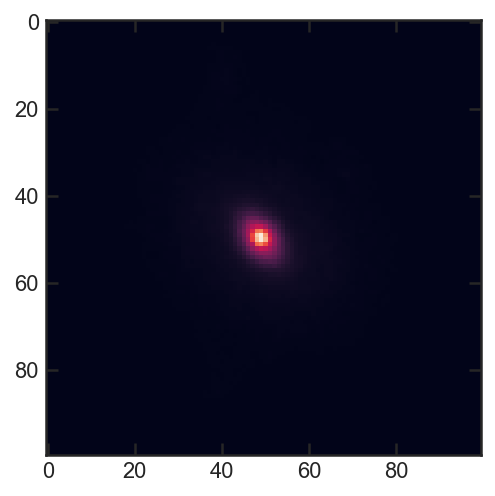

In [56]:
plt.imshow(f160img)

In [61]:

for i in hsdb.index:
    exist = os.path.isfile('../data/imgfiles/{}_{}.npy'.format(mdb.field[i], mdb.id[i]))
    if not exist:
        print('{}-{}'.format(mdb.field[i], mdb.id[i]))
        
for i in lsdb.index:
    exist = os.path.isfile('../data/imgfiles/{}_{}.npy'.format(mdb.field[i], mdb.id[i]))
    if not exist:
        print('{}-{}'.format(mdb.field[i], mdb.id[i]))

In [98]:
img1 = 0
for i in hsdb.index:
    if np.max(np.load('../data/imgfiles/{}_{}.npy'.format(mdb.field[i], mdb.id[i]))) > 0:
        img1 += np.load('../data/imgfiles/{}_{}.npy'.format(mdb.field[i], mdb.id[i])) / np.max(np.load('../data/imgfiles/{}_{}.npy'.format(mdb.field[i], mdb.id[i])))
        print(np.max(np.load('../data/imgfiles/{}_{}.npy'.format(mdb.field[i], mdb.id[i]))))
img2 = 0
for i in lsdb.index:
    if np.max(np.load('../data/imgfiles/{}_{}.npy'.format(mdb.field[i], mdb.id[i]))) > 0:
        img2 += np.load('../data/imgfiles/{}_{}.npy'.format(mdb.field[i], mdb.id[i])) / np.max(np.load('../data/imgfiles/{}_{}.npy'.format(mdb.field[i], mdb.id[i])))

2.5755978
1.9326841
4.525421
3.127474
1.8852344
3.128615
0.89934826
1.1997147
1.6062216
0.6276378
0.619433
1.2677842
0.5302618
0.8105003
0.8710841


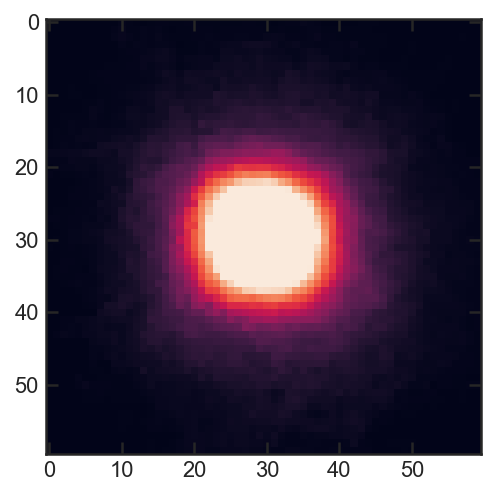

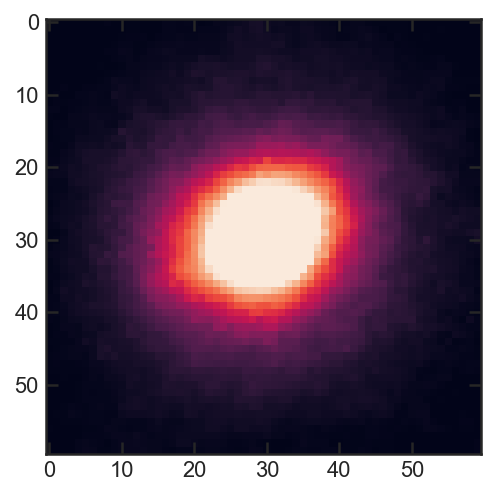

In [101]:
plt.figure()
plt.imshow(np.arcsinh(img1), vmin = np.percentile(np.arcsinh(img1),5), vmax = np.percentile(np.arcsinh(img1),95))

plt.figure()
plt.imshow(np.arcsinh(img2), vmin = np.percentile(np.arcsinh(img2),5), vmax = np.percentile(np.arcsinh(img2),95))


In [83]:
np.median(np.load('../data/imgfiles/{}_{}.npy'.format(mdb.field[i], mdb.id[i])))

0.020733576